## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42

In [2]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# !cp -r drive/MyDrive/datasets_hi4 .

In [3]:
data = pd.read_csv("datasets_hi4/train-data.csv",sep=";")

In [4]:
data

,index,id_product,Region,Country,Site,Operations,Zone,Cluster,Reference proxy,Product Line proxy,Division proxy,Customer Persona proxy,Strategic Product Family proxy,Product Life cycel status,Date,Month 1,Month 2,Month 3,Month 4
0,645874,156160,EUROPE,DE,NL_DC_Venray,Europe Operations,DACH,Germany,reference-13523,Product Line-4,Division-3,Customer Segmentation-3,Strategic Product Family-12,NaN,may-aug 2021,0,0,0,0
1,469488,224631,CHINA,CN,CN_DC_Shanghai,China Operations,China & HK,China,reference-12778,Product Line-4,Division-3,Customer Segmentation-14,Strategic Product Family-9,NaN,jan-apr 2021,0,1,0,0
2,348904,104047,EUROPE,GB,NL_DC_HLD,Europe Operations,UK and Ireland,United Kingdom,reference-3513,Product Line-3,Division-2,Customer Segmentation-23,Strategic Product Family-7,NaN,jan-apr 2021,0,2,0,0
3,1725822,11823,EAJP,AU,AU_DC_Perth,International Operations,Pacific,Australia,reference-672,Product Line-1,Division-1,Customer Segmentation-11,Strategic Product Family-3,NaN,jan-apr 2023,0,0,0,0
4,404781,159924,EUROPE,ES,NL_DC_HLD,Europe Operations,Iberia,Spain,reference-3496,Product Line-3,Division-2,Customer Segmentation-14,Strategic Product Family-7,NaN,jan-apr 2021,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3173341,1285020,60735,NAM,US,US_DC_Mechanicsburg,North America Operations,US,USA,reference-6024,Product Line-4,Division-3,Customer Segmentation-4,Strategic Product Family-12,EOL,may-aug 2022,0,0,0,0
3173342,1527076,57934,NAM,US,US_DC_Athens,North America Operations,US,USA,reference-5672,Product Line-4,Division-3,Customer Segmentation-43,Strategic Product Family-9,NaN,sep-dec 2022,0,0,0,0
3173343,306473,61616,NAM,US,US_DC_Mechanicsburg,North America Operations,US,USA,reference-6241,Product Line-4,Division-3,Customer Segmentation-46,Strategic Product Family-12,NaN,jan-apr 2021,0,0,0,0
3173344,205624,205624,EUROPE,FR,FR_DC_Evreux,France Operations,France,France,reference-11174,Product Line-4,Division-3,Customer Segmentation-1,Strategic Product Family-9,NaN,sep-dec 2020,0,1,0,0


In [5]:
data.columns

Index(['index', 'id_product', 'Region', 'Country', 'Site', 'Operations',
       'Zone', 'Cluster', 'Reference proxy', 'Product  Line proxy',
       'Division proxy', 'Customer Persona proxy',
       'Strategic Product Family proxy', 'Product Life cycel status', 'Date',
       'Month 1', 'Month 2', 'Month 3', 'Month 4'],
      dtype='object')

In [6]:
data.isna().sum()

index                                   0
id_product                              0
Region                                  0
Country                                 0
Site                                    0
Operations                              0
Zone                                    0
Cluster                                 0
Reference proxy                         0
Product  Line proxy                     0
Division proxy                          0
Customer Persona proxy                  0
Strategic Product Family proxy          0
Product Life cycel status         2742544
Date                                    0
Month 1                            352330
Month 2                                 0
Month 3                                 0
Month 4                                 0
dtype: int64

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3173346 entries, 0 to 3173345
Data columns (total 19 columns):
 #   Column                          Dtype 
---  ------                          ----- 
 0   index                           int64 
 1   id_product                      int64 
 2   Region                          object
 3   Country                         object
 4   Site                            object
 5   Operations                      object
 6   Zone                            object
 7   Cluster                         object
 8   Reference proxy                 object
 9   Product  Line proxy             object
 10  Division proxy                  object
 11  Customer Persona proxy          object
 12  Strategic Product Family proxy  object
 13  Product Life cycel status       object
 14  Date                            object
 15  Month 1                         object
 16  Month 2                         object
 17  Month 3                         object
 18  Mo

In [8]:
duplicate_rows = data[data.duplicated()]
if not duplicate_rows.empty:
    data = data.drop_duplicates(keep='first')

In [9]:
data["Month 1"] = data["Month 1"].apply(lambda x: int(x.replace(" ","")) if isinstance(x, str) else x)
data["Month 2"] = data["Month 2"].apply(lambda x: x.replace(" ","")).astype(int)
data["Month 3"] = data["Month 3"].apply(lambda x: x.replace(" ","")).astype(int)
data["Month 4"] = data["Month 4"].apply(lambda x: x.replace(" ","")).astype(int)

def fill_nan_with_mean(row):
    if pd.isna(row['Month 1']):
        return (row['Month 2'] + row['Month 3']) // 2
    else:
        return row['Month 1']

data['Month 1'] = data.apply(fill_nan_with_mean, axis=1)
data['Month 1'] = data['Month 1'].astype(int)

In [10]:
data['start_date'] = data['Date'].apply(lambda x : x.split("-")[0])
data['end_date'] = data['Date'].apply(lambda x : x.split("-")[1][:3])
data['year'] = data["Date"].apply(lambda x: int(x.split(" ")[1]))

In [11]:
def assign_period(month):
    if month == 'jan':
        return 1
    elif month == 'may':
        return 2
    elif month == 'sep':
        return 3
    else:
        return np.nan

data['Period'] = data['start_date'].apply(assign_period)

In [12]:
data

,index,id_product,Region,Country,Site,Operations,Zone,Cluster,Reference proxy,Product Line proxy,...,Product Life cycel status,Date,Month 1,Month 2,Month 3,Month 4,start_date,end_date,year,Period
0,645874,156160,EUROPE,DE,NL_DC_Venray,Europe Operations,DACH,Germany,reference-13523,Product Line-4,...,NaN,may-aug 2021,0,0,0,0,may,aug,2021,2
1,469488,224631,CHINA,CN,CN_DC_Shanghai,China Operations,China & HK,China,reference-12778,Product Line-4,...,NaN,jan-apr 2021,0,1,0,0,jan,apr,2021,1
2,348904,104047,EUROPE,GB,NL_DC_HLD,Europe Operations,UK and Ireland,United Kingdom,reference-3513,Product Line-3,...,NaN,jan-apr 2021,0,2,0,0,jan,apr,2021,1
3,1725822,11823,EAJP,AU,AU_DC_Perth,International Operations,Pacific,Australia,reference-672,Product Line-1,...,NaN,jan-apr 2023,0,0,0,0,jan,apr,2023,1
4,404781,159924,EUROPE,ES,NL_DC_HLD,Europe Operations,Iberia,Spain,reference-3496,Product Line-3,...,NaN,jan-apr 2021,0,0,0,0,jan,apr,2021,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3173317,1445304,221019,CHINA,CN,CN_DC_SHD,China Operations,China & HK,China,reference-17197,Product Line-2,...,NaN,may-aug 2022,0,0,0,0,may,aug,2022,2
3173331,738575,4004,EAJP,AU,AU_DC_Perth,International Operations,Pacific,Australia,reference-309,Product Line-1,...,EOL,sep-dec 2021,0,1,0,0,sep,dec,2021,3
3173333,68026,68026,NAM,US,US_DC_Mechanicsburg,North America Operations,US,USA,reference-7393,Product Line-4,...,NaN,sep-dec 2020,18,1,0,0,sep,dec,2020,3
3173334,1841243,127244,EUROPE,IT,IT_DC_Venaria,Europe Operations,Italy,Italy,reference-8620,Product Line-4,...,NaN,jan-apr 2023,0,1,0,0,jan,apr,2023,1


In [13]:
data["Product Life cycel status"].fillna("Active",inplace=True)
data['Customer Persona proxy'] = data['Customer Persona proxy'].apply(lambda x: x.replace("Customer Segmentation-", ""))
data['Product  Line proxy'] = data['Product  Line proxy'].apply(lambda x: x.replace("Product Line-", ""))
data['Reference proxy'] = data['Reference proxy'].apply(lambda x: x.replace("reference-", ""))
data['Division proxy'] = data['Division proxy'].apply(lambda x: x.replace("Division-", ""))
data['Strategic Product Family proxy'] = data['Strategic Product Family proxy'].apply(lambda x: x.replace("Strategic Product Family-", ""))
data['Trend 1'] = data['Month 2'] - data['Month 1']
data['Trend 2'] = data['Month 3'] - data['Month 2']

In [14]:
data = data[(data['Month 1'] < data['Month 1'].quantile(0.99)) &
            (data['Month 2'] < data['Month 2'].quantile(0.99)) &
            (data['Month 3'] < data['Month 3'].quantile(0.99))]

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1735034 entries, 0 to 3173343
Data columns (total 25 columns):
 #   Column                          Dtype 
---  ------                          ----- 
 0   index                           int64 
 1   id_product                      int64 
 2   Region                          object
 3   Country                         object
 4   Site                            object
 5   Operations                      object
 6   Zone                            object
 7   Cluster                         object
 8   Reference proxy                 object
 9   Product  Line proxy             object
 10  Division proxy                  object
 11  Customer Persona proxy          object
 12  Strategic Product Family proxy  object
 13  Product Life cycel status       object
 14  Date                            object
 15  Month 1                         int64 
 16  Month 2                         int64 
 17  Month 3                         int64 
 18  Mo

In [16]:
data.drop(['index', 'id_product', 'Country', 'Region', 'Site', 'Reference proxy'], axis=1, inplace =True)

In [17]:
data

,Operations,Zone,Cluster,Product Line proxy,Division proxy,Customer Persona proxy,Strategic Product Family proxy,Product Life cycel status,Date,Month 1,Month 2,Month 3,Month 4,start_date,end_date,year,Period,Trend 1,Trend 2
0,Europe Operations,DACH,Germany,4,3,3,12,Active,may-aug 2021,0,0,0,0,may,aug,2021,2,0,0
1,China Operations,China & HK,China,4,3,14,9,Active,jan-apr 2021,0,1,0,0,jan,apr,2021,1,1,-1
2,Europe Operations,UK and Ireland,United Kingdom,3,2,23,7,Active,jan-apr 2021,0,2,0,0,jan,apr,2021,1,2,-2
3,International Operations,Pacific,Australia,1,1,11,3,Active,jan-apr 2023,0,0,0,0,jan,apr,2023,1,0,0
4,Europe Operations,Iberia,Spain,3,2,14,7,Active,jan-apr 2021,0,0,0,0,jan,apr,2021,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3173317,China Operations,China & HK,China,2,2,28,5,Active,may-aug 2022,0,0,0,0,may,aug,2022,2,0,0
3173331,International Operations,Pacific,Australia,1,1,8,3,EOL,sep-dec 2021,0,1,0,0,sep,dec,2021,3,1,-1
3173333,North America Operations,US,USA,4,3,4,9,Active,sep-dec 2020,18,1,0,0,sep,dec,2020,3,-17,-1
3173334,Europe Operations,Italy,Italy,4,3,4,12,Active,jan-apr 2023,0,1,0,0,jan,apr,2023,1,1,-1


In [18]:
data.isna().sum()

Operations                        0
Zone                              0
Cluster                           0
Product  Line proxy               0
Division proxy                    0
Customer Persona proxy            0
Strategic Product Family proxy    0
Product Life cycel status         0
Date                              0
Month 1                           0
Month 2                           0
Month 3                           0
Month 4                           0
start_date                        0
end_date                          0
year                              0
Period                            0
Trend 1                           0
Trend 2                           0
dtype: int64

## Encoding

In [19]:
data.nunique()

Operations                           5
Zone                                12
Cluster                             18
Product  Line proxy                  6
Division proxy                       3
Customer Persona proxy              72
Strategic Product Family proxy      19
Product Life cycel status            4
Date                                 9
Month 1                            381
Month 2                            360
Month 3                            400
Month 4                           1184
start_date                           3
end_date                             4
year                                 4
Period                               3
Trend 1                            728
Trend 2                            748
dtype: int64

In [20]:
ohe_columns = ['Operations', 'Zone', 'Cluster', 'Product  Line proxy', 'Division proxy', 'Customer Persona proxy', 'Strategic Product Family proxy', 'Product Life cycel status']
data = pd.get_dummies(data, columns=ohe_columns)

## Train-test split

In [21]:
X, y = data.drop(['Date', 'start_date', 'end_date', 'Month 4'], axis=1), data['Month 4']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

## Scaling

In [23]:
scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,...,136,137,138,139,140,141,142,143,144,145
0,0.000000,0.000000,0.000000,0.333333,0.0,0.514905,0.472919,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.000000,0.005571,0.017544,0.333333,0.0,0.517615,0.479524,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,1.000000,0.0,0.514905,0.472919,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.333333,0.0,0.514905,0.472919,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,1.000000,0.5,0.514905,0.472919,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1388022,0.000000,0.000000,0.000000,0.000000,1.0,0.514905,0.472919,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1388023,0.136842,0.064067,0.243108,0.666667,0.0,0.475610,0.570674,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1388024,0.010526,0.000000,0.000000,0.666667,0.0,0.509485,0.472919,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1388025,0.000000,0.000000,0.000000,0.333333,0.5,0.514905,0.472919,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Lasso

In [25]:
lasso = Lasso().fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)

lasso_rmse = mean_squared_error(y_test, lasso_pred, squared=False)
print(lasso_rmse)

212.30056219789844


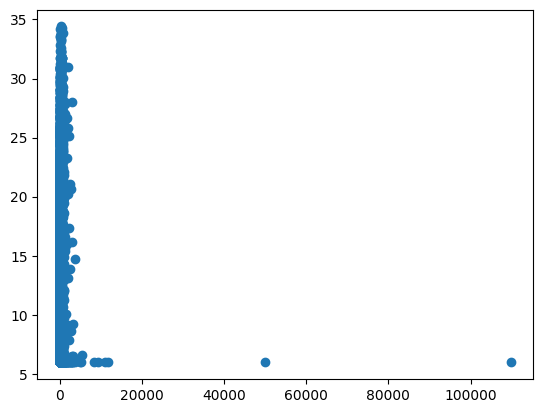

In [26]:
plt.scatter(y_test, lasso_pred)

In [43]:
indices = np.where(y_test < 20000)[0]
other_y_test = y_test.iloc[indices]
other_lasso_pred = lasso_pred[indices]
print(mean_squared_error(other_y_test, other_lasso_pred, squared=False))

55.94317593092534
